# Wildfire statistics

PAIRS layer `50035` contains information on _burned areas_. I.e. a pixel has the value 1 on the timestamp a burn occured. (The data is derived from http://modis-fire.umd.edu/ba.html.) Leveraging the spatial and temporal aggregation features in PAIRS allows us to calculate burned areas for each state in the US and year.

In [1]:
import os, numpy as np, pandas as pd, logging, matplotlib.pyplot as plt, re, requests, sklearn
from datetime import datetime, timedelta
from ibmpairs import paw, authentication
from urllib.parse import urljoin
from pathlib import Path

logging.basicConfig(level = logging.INFO)

pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.WARNING)

In [2]:
iso8601 = '%Y-%m-%dT%H:%M:%SZ'
yearStart, yearEnd = 2001, 2019
burnableLand = [62, 63, 64, 141, 142, 143, 152, 176]

We load our PAIRS credentials.

In [3]:
url_pairs = 'https://pairs.res.ibm.com'

In [4]:
with Path('/home/johannes/ibmpairskey.txt').open() as fp:
    pairs_api_key = fp.read().strip()
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)

In [5]:
layers_used_in_notebook = [50035, 92, 49450, 48522]

In [6]:
layer_info = {}
for l_id in layers_used_in_notebook:
    l_info = requests.get(
        urljoin(url_pairs, f'/v2/datalayers/{l_id}'), headers={
            'authorization' : f'Bearer {pairs_credentials.jwt_token}',
            'content-type' : 'application/json'
        }
    )
    if l_info.status_code != 200:
        logging.warning(f'You do not seem to have access to {l_id}.')
        continue
    logging.info(f'Established access to {l_id}.')
    layer_info[l_id] = l_info.json()
layer_info = pd.DataFrame.from_dict(layer_info)
layer_info.sort_index(axis=1, inplace=True)

INFO:root:Established access to 50035.
INFO:root:Established access to 92.
INFO:root:Established access to 49450.
INFO:root:Established access to 48522.


In [7]:
layer_info.loc[['name', 'name_alternate', 'description_short', 'description_long', 'units']]

,92,48522,49450,50035
name,Daily maximum temperature,Crop 250 m,Soil water (0 to 7 cm),Burned area
name_alternate,NaN,Crop 250 m,Volumetric soil water layer 1,NaN
description_short,Daily maximum temperature for the United States.,USA Crop Planting Map Aggregated to 250m Resol...,The short name of this parameter (as used in t...,Indicates (with a value of 1) whether an area ...
description_long,NaN,250m down-sampled yearly Cropscape Data Layer,The volume of water in the soil layer. It is a...,NaN
units,K,NaN,m3 m-3,Boolean


The following JSON defines the PAIRS query. We are requesting years 2010 to 2018. Since we are interested in the aggregate annual burned areas, we are performing a `Max` aggregation. (Since pixels in this layer have the value 1 exclusively, `Min` and `Mean` would give the same result. `Sum` would not for pixels that were affected by multiple fires.)

Note that spatial aggregation is always performed _last_ in PAIRS. In the case at hand, we aggregate across US states.

In [8]:
queryJson = {
    "layers": [
        {   
            "alias" : "B{y}".format(y = y),
            "id": '50035',
            "output": True,
            "temporal" : {"intervals" : [{
                "start" : datetime(y, 1, 1).strftime(iso8601), "end" : datetime(y+1, 1, 1).strftime(iso8601)
            }]},
            "aggregation" : "Max",
            "type": "raster"
        }
    for y in range(yearStart, yearEnd)],
    "name": "Burned areas",
    "spatial" : {
        "type" : "poly", "aoi" : "24",
        "aggregation": {
            "aoi": [
                i for i in range(121, 172)
            ]
        }
    },
    "temporal": {"intervals": [{"start" : datetime(2019, 1, 1).strftime(iso8601), "end" : datetime(2020, 1, 1).strftime(iso8601)}]},
}

However, we are not only interested in the wildfire data. Since PAIRS offers a multitude of additional data layers, we can look for statistically significant dependencies. Thus we add layers `92` and `49450`. The former is the daily maximum temperature as reported by PRISM, the latter hourly soil moisture at a depth of 0-7 cm in m3/m3. The soil moisture data is from the ERA5 reanalysis dataset.

In [9]:
queryJson["layers"].extend([
    {   
        "alias" : "TMax{y}".format(y = y),
        "id": '92',
        "output": True,
        "temporal" : {"intervals" : [{
            "start" : datetime(y, 1, 1).strftime(iso8601), "end" : datetime(y+1, 1, 1).strftime(iso8601)
        }]},
        "aggregation" : "Max",
        "type": "raster"
    }
    for y in range(yearStart, yearEnd)
])
queryJson["layers"].extend([
    {   
        "alias" : "SW{y}".format(y = y),
        "id": '49450',
        "output": True,
        "temporal" : {"intervals" : [{
            "start" : datetime(y, 1, 1).strftime(iso8601), "end" : datetime(y+1, 1, 1).strftime(iso8601)
        }]},
        "aggregation" : "Mean",
        "type": "raster"
    }
    for y in range(yearStart, yearEnd)
])

In [10]:
query = paw.PAIRSQuery(queryJson, url_pairs, pairs_credentials, authType='api-key')
query.submit()

**Note** Spatial aggregation is not the fastest process. This might take an hour to run. Moreover, the authentication token might expire during that time. The following code checks on the status of the query (`query.poll()`) and then updates credentials if necessary (`pairs_credentials.refresh_auth_token()`).

In [25]:
query.poll()
if query.queryStatus.status_code == 403:
    pairs_credentials.refresh_auth_token()
query.queryStatus.json()['status']

'Succeeded'

In [26]:
query.poll_till_finished()
query.download()

In [27]:
query.create_layers()

Since all the data is aggregated by state, PAIRS essentially returns a number of data frames in the form of csv files.

# Analysis

The first step in our analysis is some simple data munging. We take the various data frames returned by PAIRS and wrapped in `query.data` and extract the features we are interested in. For the burned area data this is the area, which can be found in the `count()[unit: km^2]` statistic. For the maximum temperature we choose the spatial maximum, for the soil water content the spatial mean.

In [28]:
from sklearn import linear_model

In [33]:
tmaxData = list()
burnData = list()
swData = list()
for k in query.data.keys():
    swYear = re.match('Global weather \(ERA5\)\-Soil water \(0 to 7 cm\)\[SW([0-9]{4})\]\-Mean', k)
    tmaxYear = re.match('Daily US weather \(PRISM\)\-Daily maximum temperature\[TMax([0-9]{4})\]\-Max', k)
    burnedYear = re.match('Burned area \(MODIS\)\-Burned area\[B([0-9]{4})\]\-Max', k)
    
    if tmaxYear:
        query.data[k]['Year'] = int(tmaxYear.group(1))
        tmaxData.append(query.data[k])
    elif burnedYear:
        query.data[k]['Year'] = int(burnedYear.group(1))
        burnData.append(query.data[k])
    elif swYear:
        query.data[k]['Year'] = int(swYear.group(1))
        swData.append(query.data[k])
    else:
        raise Exception('No match for key {}.'.format(k))
tmaxData = pd.concat(tmaxData, axis=0).reset_index(drop = True)
burnData = pd.concat(burnData, axis=0).reset_index(drop = True)
swData = pd.concat(swData, axis=0).reset_index(drop = True)

Later on we will analyze the data by state. To do so, we load information on the various AOIs from PAIRS. Strictly speaking we are not only aggregating by state since we treat the District of Columbia separately.

In [35]:
aoiDetails = [
    requests.get(
        urljoin(url_pairs, f'/ws/queryaois/aoi/{aoi}'),
        headers={
            'authorization' : f'Bearer {pairs_credentials.jwt_token}',
            'content-type' : 'application/json'
        }
    ).json()
    for aoi in range(121, 172)
]
aoiDetails = pd.DataFrame(aoiDetails)

In [36]:
allTheData = pd.merge(
    burnData[['PAIRS polygon ID', 'Year', 'count()[unit: km^2]']],
    tmaxData[['PAIRS polygon ID', 'Year', 'max()']],
    on = ['PAIRS polygon ID', 'Year'], how = 'outer'
).rename(columns = {'count()[unit: km^2]' : 'BurnedArea', 'max()' : 'TMax'})
allTheData['BurnedArea'].fillna(0, inplace = True)
allTheData = pd.merge(allTheData, swData[['PAIRS polygon ID', 'Year', 'mean()']], on = ['PAIRS polygon ID', 'Year'], how = 'outer').rename(columns = {'mean()' : 'SoilWater'})
allTheData = pd.merge(allTheData, aoiDetails[['id', 'name']], left_on = 'PAIRS polygon ID', right_on = 'id', how = 'inner').drop(['PAIRS polygon ID', 'id'], axis = 1)

## Conterminous USA

To start, we take a look at the conterminous USA. (If we wanted to analyze Hawaii or Alaska, we could not use the PRISM data. An obvious replacement would be datasets 190 or 157, the _Global weather (ERA5)_ and _Current and historical weather (IBM TWC)_ respectively.

In [37]:
conusData = allTheData.groupby('Year').aggregate({'BurnedArea' : np.sum, 'TMax' : np.mean, 'SoilWater' : np.mean})

In [38]:
conusData.corr()

,BurnedArea,TMax,SoilWater
BurnedArea,1.000000,0.487211,-0.315094
TMax,0.487211,1.000000,-0.706799
SoilWater,-0.315094,-0.706799,1.000000


Having take a look at correlations, we fit 3 models -- one for each combination of independent variables.

In [39]:
conusModel = linear_model.LinearRegression()
conusModel.fit(conusData[['TMax']] - conusData[['TMax']].mean(), conusData['BurnedArea'])
conusModel.score(conusData[['TMax']] - conusData[['TMax']].mean(), conusData['BurnedArea'])

0.23737445551933467

In [40]:
conusModel2 = linear_model.LinearRegression()
conusModel2.fit(conusData[['TMax', 'SoilWater']] - conusData[['TMax', 'SoilWater']].mean(), conusData['BurnedArea'])
conusModel2.score(conusData[['TMax', 'SoilWater']] - conusData[['TMax', 'SoilWater']].mean(), conusData['BurnedArea'])

0.2390859665955769

In [41]:
conusModel3 = linear_model.LinearRegression()
conusModel3.fit(conusData[['SoilWater']] - conusData[['SoilWater']].mean(), conusData['BurnedArea'])
conusModel3.score(conusData[['SoilWater']] - conusData[['SoilWater']].mean(), conusData['BurnedArea'])

0.09928444879527654

As one might expect the model containing both maximum temperature and soil water is best in terms of $R^2$ score. However, the improvement is marginal. For simplicity we continue our analysis focussing on a simple linear dependence between burned area and maximum temperature.

In [42]:
X = np.linspace(
    conusData['TMax'].min() - conusData['TMax'].mean(),
    conusData['TMax'].max() - conusData['TMax'].mean(), 100
).reshape(-1, 1)
y = conusModel.predict(X)

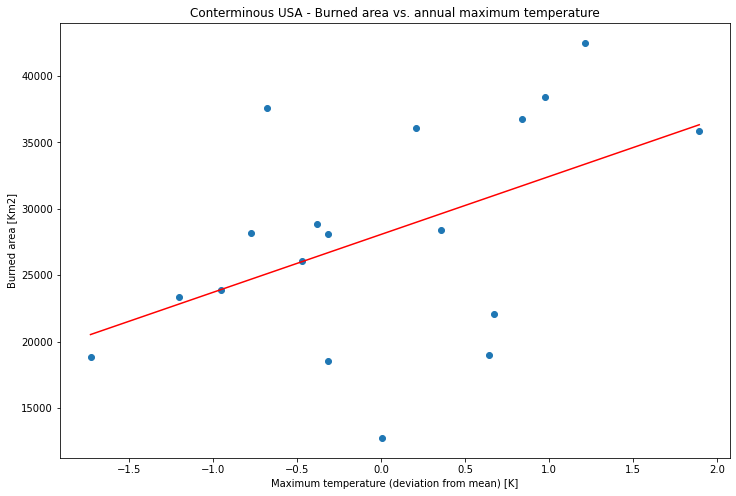

In [43]:
plt.figure(figsize = (12, 8))
plt.scatter(conusData['TMax'] - conusData['TMax'].mean(), conusData['BurnedArea'])
plt.plot(X, y, color = 'red')
plt.xlabel('Maximum temperature (deviation from mean) [K]')
plt.ylabel('Burned area [Km2]')
plt.title('Conterminous USA - Burned area vs. annual maximum temperature')
plt.savefig('linearDependence.png', bbox_inches = 'tight')
plt.show()

To evaluate our model, we calculate some statistical scores. Specifically, we calculate

$
\hat{\beta} = (X^T X)^{-1} X^T y \\
\hat{y} = X \hat{\beta} \\
\hat{\sigma}^2 = \frac{1}{N-p-1} \sum (y - \hat{y})^2 \\
Var(\hat{\beta}) = (X^T X)^{-1} \hat{\sigma}^2 \\
v_j = (X^T X)^{-1}_{jj} \\
z_j = \frac{\hat{\beta}_j}{\hat{\sigma} \sqrt{v_j}}
$

In [44]:
X = (conusData[['TMax']] - conusData[['TMax']].mean())
X['1'] = 1
X = X[['1', 'TMax']].values
y = conusData['BurnedArea'].values

betaHat = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), X.transpose()), y)
yHat = np.matmul(X, betaHat)
sigmaHat2 = np.power(y - yHat, 2).sum() / (len(y) - 1 - 1)
VarBeta = np.linalg.inv(np.matmul(X.transpose(), X)) * sigmaHat2
v = np.array([np.linalg.inv(np.matmul(X.transpose(), X))[i, i] for i in range(2)])
zScore = betaHat / (np.sqrt(sigmaHat2 * v))

In [45]:
zScore

array([15.88731182,  2.23162546])

## Per-state analysis

To proceed, we would like to evaluate and compare different states. This poses a problem however: How do we best compare areas affected by wildfires across states with vastly different spatial coverage? An additional $1 Km^2$ in Rhode Island is a very different situation to an additional $1 Km^2$ in Alaska. One possibility is to normalize the burned area we are considering before by the _burnable area_; i.e. the fraction of a state's area that is covered by forests, shrubland or other vegetation that is susceptible to wildfires. To do so, we will query layer `48522`, which contains land use data from the US Department of Agriculture. The original data has 30 m resolution. `48522` is a convenience product that contains the same information coarse-grained to 250 m.

Note: One can certainly argue whether our methodology is correct. From an ecological perspective, every square kilometer of burned area is problematic, no matter where. Having said that, note that the mathematics of our linear fits will not be affected by a simple rescaling of the dependent variable.

### Normalizing the area

In either case, we proceed by grabbing the data from layer `48522`. In principle one could do this for each year or aggregate over multiple years. In what follows we simply use 2016 as a representative.

In [46]:
burnableAreaQueryJson = {
    "layers": [
        {   
            "alias" : "crop2016",
            "id": '48522',
            "output": False,
            "temporal" : {"intervals" : [{
                "snapshot" : datetime(2016, 1, 1).strftime(iso8601)
            }]},
            "type": "raster"
        },
        {   
            "alias" : "burnable2016",
            "output": True,
            "expression" : "0 + (" + " || ".join(["($crop2016 == {})".format(crop) for crop in burnableLand]) + ")"
        }
    ],
    "name": "BurnedAreas",
    "spatial" : {
        "type" : "poly", "aoi" : "24",
        "aggregation" : {"aoi" : list(range(121, 172))}
    },
    "temporal": {"intervals": [{"start" : datetime(2019, 1, 1).strftime(iso8601), "end" : datetime(2020, 1, 1).strftime(iso8601)}]},
}

In [48]:
burnableAreaQuery = paw.PAIRSQuery(burnableAreaQueryJson, url_pairs, pairs_credentials, authType='api-key')
burnableAreaQuery.submit()

In [49]:
burnableAreaQuery.poll_till_finished()
burnableAreaQuery.download()

In [50]:
burnableAreaQuery.create_layers()

Having completed the query, we join the data ...

In [52]:
burnableArea = pd.merge(
    burnableAreaQuery.data['Expression-burnable2016[burnable2016]-Exp'],
    aoiDetails[['id', 'name']], left_on = 'PAIRS polygon ID', right_on = 'id', how = 'inner'
).drop(['PAIRS polygon ID', 'id', 'min()', 'max()', 'mean()', '2nd moment'], axis=1).rename(columns = {'count()[unit: km^2]' : 'BurnableArea'})

... and calculate the aforementioned fraction.

In [53]:
evenMoreData = pd.merge(allTheData, burnableArea, on = 'name', how = 'outer')
evenMoreData['BurnedFraction'] = evenMoreData['BurnedArea'] / evenMoreData['BurnableArea'] * 100

We are now in the position to fit a linear model for each state. As we are ignoring Alaska and Hawaii and are treating D.C. as a state, we have exactly 49 states which we can nicely arrange in a grid:

/tmp/ipykernel_2471163/4250108812.py:22: RuntimeWarning: invalid value encountered in true_divide
  zScore = betaHat / (np.sqrt(sigmaHat2 * v))
/tmp/ipykernel_2471163/4250108812.py:22: RuntimeWarning: invalid value encountered in true_divide
  zScore = betaHat / (np.sqrt(sigmaHat2 * v))
/tmp/ipykernel_2471163/4250108812.py:22: RuntimeWarning: invalid value encountered in true_divide
  zScore = betaHat / (np.sqrt(sigmaHat2 * v))


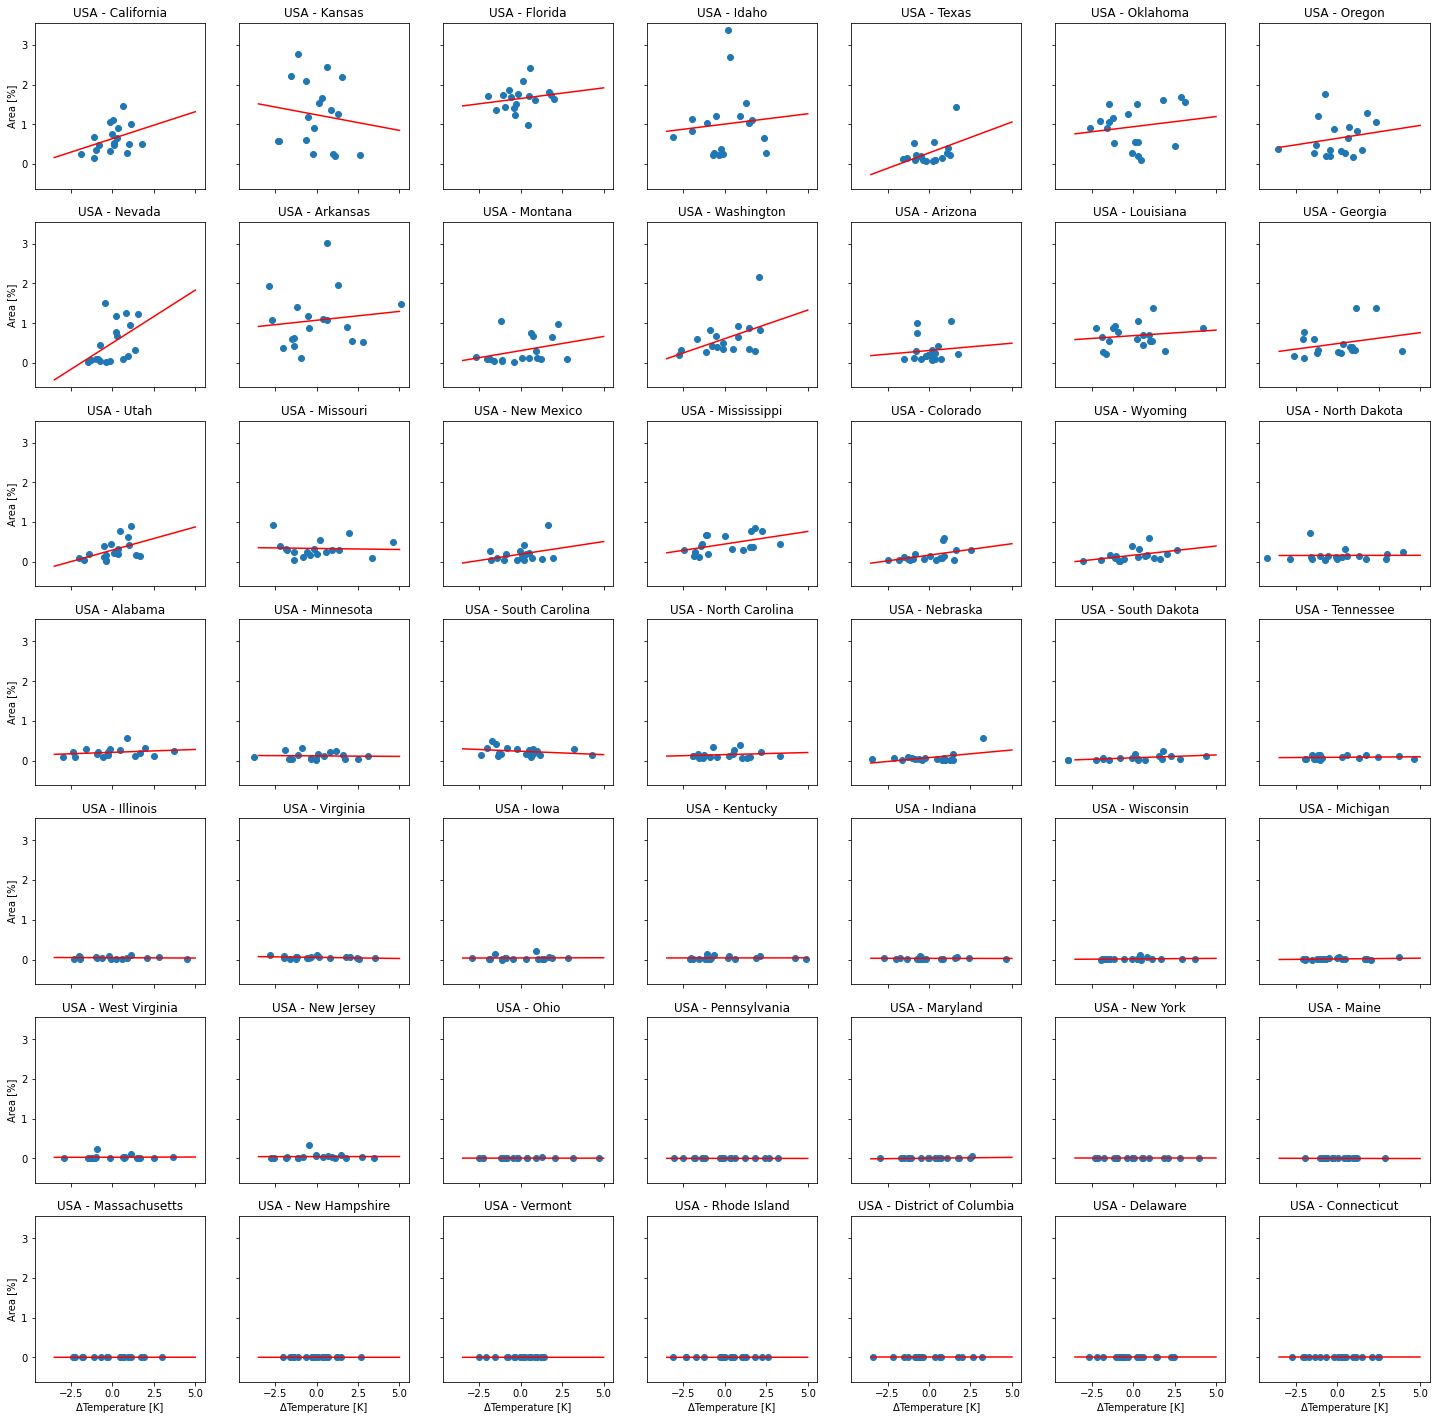

In [54]:
fig, ax = plt.subplots(7, 7, figsize = (25, 25), sharex = True, sharey = True)
betaHats, zScores, varBetaHats = dict(), dict(), dict()

for i, state in evenMoreData.groupby('name').aggregate({'BurnedArea' : np.sum}).sort_values('BurnedArea', ascending = False).index.to_series().reset_index(drop = True).iteritems():
    stateData = evenMoreData[evenMoreData['name'] == state]
    
    # We fit a model
    stateModel = linear_model.LinearRegression()
    stateModel.fit(stateData[['TMax']] - stateData[['TMax']].mean(), stateData['BurnedFraction'])
    
    # Evaluating the model
    X = (stateData[['TMax']] - stateData[['TMax']].mean())
    X['1'] = 1
    X = X[['1', 'TMax']].values
    y = stateData['BurnedFraction'].values

    betaHat = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), X.transpose()), y)
    yHat = np.matmul(X, betaHat)
    sigmaHat2 = np.power(y - yHat, 2).sum() / (len(y) - 1 - 1)
    varBetaHat = np.linalg.inv(np.matmul(X.transpose(), X)) * sigmaHat2
    v = np.array([np.linalg.inv(np.matmul(X.transpose(), X))[i, i] for i in range(2)])
    zScore = betaHat / (np.sqrt(sigmaHat2 * v))
    
    betaHats[state] = betaHat[1]
    zScores[state] = zScore[1]
    varBetaHats[state] = varBetaHat[1, 1]
    
    # Plotting
    X = np.linspace(-3.5, 5.0, 100).reshape(-1, 1)
    y = stateModel.predict(X)
    
    row = i//7
    column = i % 7
    
    ax[row, column].scatter(stateData['TMax'] - stateData['TMax'].mean(), stateData['BurnedFraction'])
    ax[row, column].plot(X, y, color = 'red')
    ax[row, column].set_title(state)
    
for a in ax.flat:
    a.set(xlabel='ΔTemperature [K]', ylabel='Area [%]')
    a.label_outer()
plt.savefig('linarDependenceByState.png', bbox_inches = 'tight')
plt.show()

To conclude, we pick the states with significant z-scores. Interestingly, this does not include California, which shows us how noisy this data is.

In [55]:
scoreSummary = pd.merge(pd.DataFrame({'z' : zScores, 'beta' : betaHats, 'Var(beta)' : varBetaHats}).sort_values('z', ascending = False), evenMoreData.groupby('name').aggregate({'BurnedArea' : np.sum, 'BurnedFraction' : np.mean}), left_index = True, right_index = True)

In [56]:
scoreSummary[scoreSummary['z'].abs() > 2.0].sort_values('BurnedArea', ascending = False)

,z,beta,Var(beta),BurnedArea,BurnedFraction
USA - Texas,2.012502,0.155490,0.005969,35706.590822,0.279845
USA - Nevada,2.151779,0.265898,0.015270,26436.011429,0.503489
USA - Washington,2.182142,0.143704,0.004337,20104.221718,0.611004
USA - Utah,2.181380,0.116256,0.002840,12006.466727,0.295594
USA - Mississippi,2.178427,0.063168,0.000841,10546.081272,0.447222
USA - Colorado,2.089018,0.057614,0.000761,7880.706044,0.167087
USA - Nebraska,2.218719,0.038613,0.000303,2771.872195,0.076041
USA - South Dakota,2.435141,0.014536,0.000036,2665.119585,0.071393
USA - Maryland,2.262541,0.004297,0.000004,24.058649,0.005221


### Visualization

Finally, we can visualize our results

In [58]:
from shapely.geometry import shape, multipolygon
import geojson, geopandas

In [73]:
polygons = [
    (
        aoi,
        shape(geojson.loads(requests.get(
            urljoin(url_pairs, f'/ws/queryaois/geojson/{aoi}'),
            headers={
                'authorization' : f'Bearer {pairs_credentials.jwt_token}',
                'content-type' : 'application/json',
                'accept' : 'application/json'
            }
        ).json()))
    )
    for aoi in range(121, 172)
]
polygonsDF = pd.DataFrame(polygons, columns = ['id', 'Geometry'])
polygonsDF = pd.merge(polygonsDF, aoiDetails[['id', 'name']]).drop(['id'], axis=1)

In [74]:
scoredPolygons = geopandas.GeoDataFrame(pd.merge(scoreSummary, polygonsDF, left_index = True, right_on = 'name'), geometry = 'Geometry')

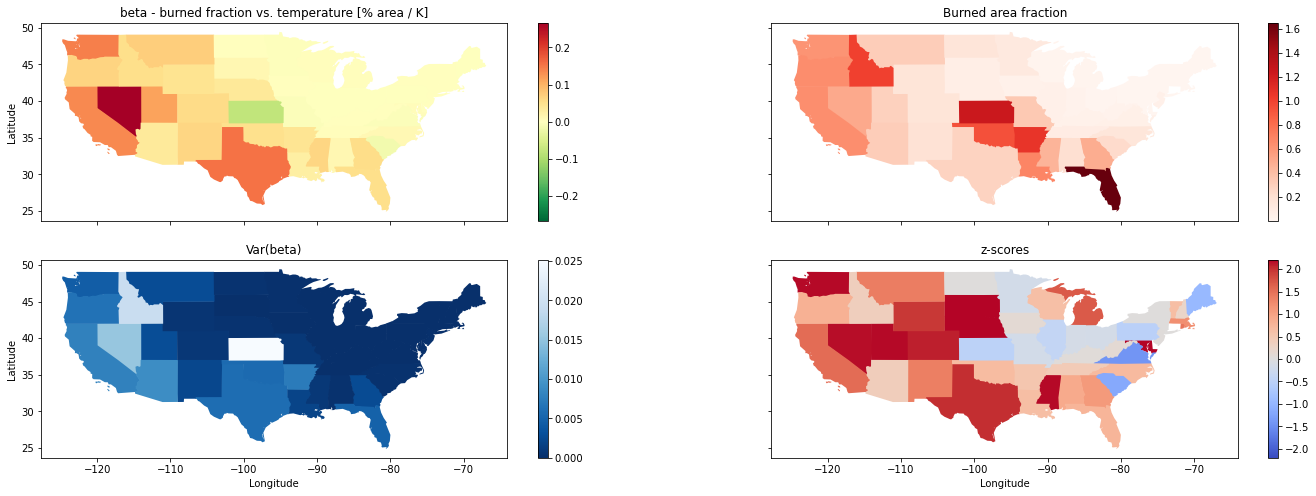

In [75]:
fig, ax = plt.subplots(2, 2, figsize = (24, 8), sharex = True, sharey = True)

scoredPolygons.plot(column = 'beta', cmap = 'RdYlGn_r', ax = ax[0][0], legend = True, vmax = scoredPolygons['beta'].abs().max(), vmin = -scoredPolygons['beta'].abs().max())
ax[0][0].set_ylabel('Latitude')
ax[0][0].set_title('beta - burned fraction vs. temperature [% area / K]')

scoredPolygons.dropna().plot(column = 'BurnedFraction', cmap = 'Reds', ax = ax[0][1], legend = True)
ax[0][1].set_title('Burned area fraction')

scoredPolygons.plot(column = 'Var(beta)', cmap = 'Blues_r', ax = ax[1][0], legend = True)
ax[1][0].set_ylabel('Latitude')
ax[1][0].set_xlabel('Longitude')
ax[1][0].set_title('Var(beta)')

scoredPolygons.dropna().plot(column = 'z', cmap = 'coolwarm', ax = ax[1][1], legend = True, vmin = -2.2, vmax = 2.2)
ax[1][1].set_xlabel('Longitude')
ax[1][1].set_title('z-scores')

plt.savefig('maps.png', dpi = 60, bbox_inches = 'tight')
plt.show()